In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession\
            .builder\
            .appName('ulec8')\
            .master('local[*]')\
            .enableHiveSupport()\
            .getOrCreate()

In [4]:
spark

In [5]:
groceries = spark.read.json('complete_groceries.json')

In [6]:
type(groceries)

pyspark.sql.dataframe.DataFrame

In [8]:
groceries.printSchema()

root
 |-- ammount: long (nullable = true)
 |-- delivery_address: struct (nullable = true)
 |    |-- city: string (nullable = true)
 |    |-- state: string (nullable = true)
 |    |-- street: string (nullable = true)
 |-- month: string (nullable = true)
 |-- order_id: long (nullable = true)
 |-- priority: long (nullable = true)
 |-- purchases: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- storage_location: struct (nullable = true)
 |    |-- city: string (nullable = true)
 |    |-- state: string (nullable = true)
 |    |-- street: string (nullable = true)
 |-- year: long (nullable = true)



In [9]:
groceries.show(1)

+-------+--------------------+-----+--------+--------+--------------------+--------------------+----+
|ammount|    delivery_address|month|order_id|priority|           purchases|    storage_location|year|
+-------+--------------------+-----+--------+--------+--------------------+--------------------+----+
|    253|[Johntown, South ...| June|  281053|       0|[Rake, Eggs, Tea,...|[South Pamelaton,...|2015|
+-------+--------------------+-----+--------+--------+--------------------+--------------------+----+
only showing top 1 row



In [10]:
groceries.ammount

Column<b'ammount'>

In [12]:
_.between(100,200)

Column<b'((((ammount >= 100) AND (ammount <= 200)) >= 100) AND (((ammount >= 100) AND (ammount <= 200)) <= 200))'>

In [15]:
groceries.select(groceries.delivery_address.state,
                groceries.ammount,
                groceries.ammount.between(100,200))\
                .sample(.01)\
                .show(5)

+----------------------+-------+---------------------------------------+
|delivery_address.state|ammount|((ammount >= 100) AND (ammount <= 200))|
+----------------------+-------+---------------------------------------+
|                 Idaho|    561|                                  false|
|                Alaska|    660|                                  false|
|        North Carolina|    627|                                  false|
|         West Virginia|    180|                                   true|
|            California|     24|                                  false|
+----------------------+-------+---------------------------------------+
only showing top 5 rows



In [16]:
from pyspark.sql.functions import when

In [18]:
year = groceries.select('year','month','ammount')

In [23]:
desc = year.describe()

In [24]:
desc.show()

+-------+------------------+---------+------------------+
|summary|              year|    month|           ammount|
+-------+------------------+---------+------------------+
|  count|            101000|   101000|            101000|
|   mean|2015.9906138613862|     null|179.15418811881187|
| stddev| 1.414252424884683|     null|157.00952691722887|
|    min|              2014|    April|                 1|
|    max|              2018|September|               792|
+-------+------------------+---------+------------------+



In [25]:
amount_by_year = year\
                    .withColumn('flag',
                                when(year.ammount <179.154,1)\
                               .otherwise(0))

In [28]:
amount_by_year.show(10
                   )

+----+---------+-------+----+
|year|    month|ammount|flag|
+----+---------+-------+----+
|2015|     June|    253|   0|
|2018|     July|    396|   0|
|2016|     June|    561|   0|
|2015|  January|    108|   1|
|2014|      May|      4|   1|
|2017|      May|     84|   1|
|2014|      May|     42|   1|
|2017|  January|     10|   1|
|2014|September|     49|   1|
|2014|  October|    198|   0|
+----+---------+-------+----+
only showing top 10 rows



In [31]:
from pyspark.sql.functions import min,max,col,mean,stddev,count

In [32]:
evaluate = [min(col('ammount')),max(col('ammount')),
           count(col('ammount')),mean(col('ammount')),
           stddev(col('ammount'))]

In [38]:
amount_by_year\
    .groupBy('year')\
    .agg(*evaluate)\
    .sort('avg(ammount)')\
    .show()

+----+------------+------------+--------------+------------------+--------------------+
|year|min(ammount)|max(ammount)|count(ammount)|      avg(ammount)|stddev_samp(ammount)|
+----+------------+------------+--------------+------------------+--------------------+
|2016|           1|         792|         20239|178.87207866001285|  156.72054515041367|
|2014|           1|         792|         20446|178.98420228895628|  156.93844997272183|
|2015|           1|         792|         20172| 179.0688082490581|   156.3933049140212|
|2017|           1|         792|         20170|179.26688150718888|   156.9641133381762|
|2018|           1|         792|         19973|179.58649176388124|  158.05307201942833|
+----+------------+------------+--------------+------------------+--------------------+



In [37]:
amount_by_year.agg({
    'ammount':'count',
    'flag':'mean'
}).show()

+------------------+--------------+
|         avg(flag)|count(ammount)|
+------------------+--------------+
|0.5998712871287128|        101000|
+------------------+--------------+



In [39]:
amount_by_year_month = amount_by_year.groupBy(['year','month'])\
                        .agg({'ammount':'count'})

In [40]:
amount_by_year_month.show(5)

+----+---------+--------------+
|year|    month|count(ammount)|
+----+---------+--------------+
|2014|    April|          1671|
|2015| November|          1619|
|2014|September|          1621|
|2018|    March|          1634|
|2014|   August|          1723|
+----+---------+--------------+
only showing top 5 rows



In [41]:
amount_by_year_month = amount_by_year_month.toPandas()

In [42]:
amount_by_year_month.head()

,year,month,count(ammount)
0,2014,April,1671
1,2015,November,1619
2,2014,September,1621
3,2018,March,1634
4,2014,August,1723


In [43]:
amount_by_year_month['date']= amount_by_year_month['year'].astype(str)+ ' '+ amount_by_year_month['month']

In [44]:
import matplotlib.pyplot as plt

In [45]:
import seaborn as sns

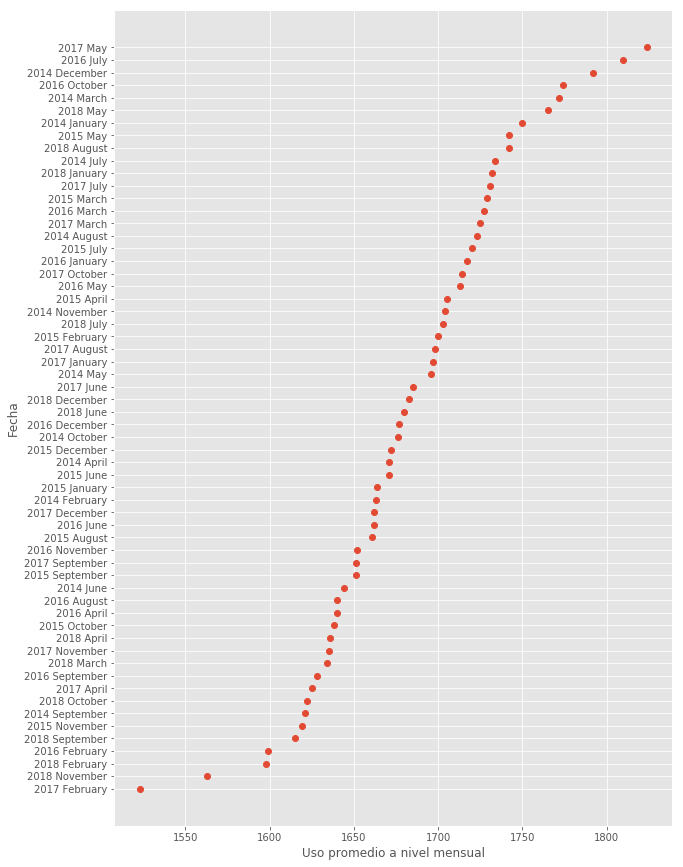

In [46]:
plt.style.use('ggplot')
plt.figure(figsize=(10,15))
amount_by_year_month = amount_by_year_month.sort_values(by = 'count(ammount)')
plt.plot(amount_by_year_month['count(ammount)'],
        amount_by_year_month['date'],
        'o')
plt.xlabel('Uso promedio a nivel mensual')
plt.ylabel('Fecha');

In [47]:
groceries.registerTempTable('groceries')

In [50]:
consulta = 'select size(purchases),ammount from groceries'

In [51]:
tamano = spark.sql(consulta).toPandas()

In [52]:
tamano.head()

,size(purchases),ammount
0,11,253
1,11,396
2,22,561
3,12,108
4,4,4


In [53]:
plt.figure(figsize=(12,8))

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

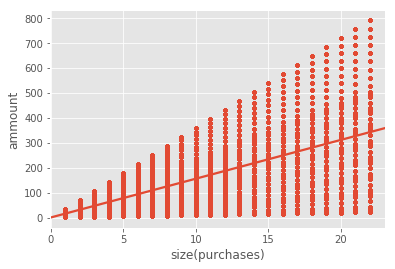

In [54]:
sns.regplot('size(purchases)','ammount',tamano,marker ='.');

In [55]:
consulta = """
select storage_location.state, corr(size(purchases),ammount) from groceries group by storage_location.state
"""
correlacion = spark.sql(consulta).toPandas()

In [56]:
correlacion.columns = ['state','corr']

In [57]:
correlacion.head()

,state,corr
0,Utah,0.621312
1,Hawaii,0.629352
2,Minnesota,0.621066
3,Ohio,0.631009
4,Arkansas,0.608372


In [58]:
correlacion = correlacion.sort_values(by='corr')

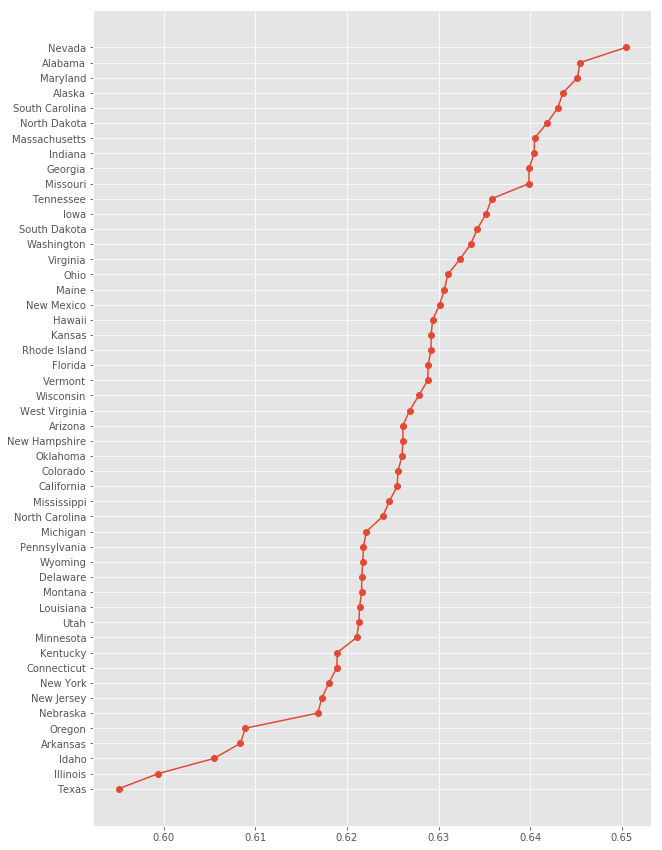

In [61]:
plt.figure(figsize=(10,15))
plt.plot(correlacion['corr'],
        correlacion['state'],
        'o-')


In [62]:
groceries.write.parquet('groceries.parquet')

In [63]:
!ls

Untitled.ipynb          derby.log               terminar.png
Untitled1.ipynb         groceries.parquet
complete_groceries.json metastore_db


In [64]:
groceries.write.parquet('groceries_fraq.parquet',partitionBy='year')

In [67]:
!ls groceries_fraq.parquet/

_SUCCESS  year=2014 year=2015 year=2016 year=2017 year=2018
